## Setup

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sun Oct 13 08:00:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install -q supervision[assets] jupyter_bbox_widget ultralytics tensorflow tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.7/882.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 21.6 MB/s eta 0:00:00


**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


### Install SAM2 and dependencies (this can take a few minutes)

You can check the homepage of the project: https://ai.meta.com/sam2/

and try the demo:

https://sam2.metademolab.com/demo




In [4]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q
!python setup.py build_ext --inplace

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 967, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 967 (delta 14), reused 18 (delta 6), pack-reused 936 (from 1)
Receiving objects: 100% (967/967), 128.94 MiB | 14.64 MiB/s, done.
Resolving deltas: 100% (331/331), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.0 MB/s eta 0:00:00
  Buil

### Download SAM2 checkpoints

**NOTE:** SAM2 is available in 4 different model sizes ranging from the lightweight "sam2_hiera_tiny" (38.9M parameters) to the more powerful "sam2_hiera_large" (224.4M parameters).

In [5]:
!mkdir -p {HOME}/checkpoints
# There are 4 options for SAM2 model:
#   - sam2_hiera_tiny.pt
#   - sam2_hiera_small.pt
#   - sam2_hiera_base_plus.pt
#   - sam2_hiera_large.pt

# download one of the, e.g. sam2_hiera_small.pt

!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints

### Imports

In [3]:
import cv2
import torch
import base64
import gc
import numpy as np
import supervision as sv

from pathlib import Path
from supervision.assets import download_assets, VideoAssets
from sam2.build_sam import build_sam2_video_predictor
import random
import glob

IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

import cv2
import glob
import os
import matplotlib.pyplot as plt
import cv2
import os

from ultralytics import YOLO  #https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/models/v8/yolov8-seg.yaml
import ultralytics
ultralytics.checks()

from google.colab import drive
drive.mount('/content/drive')
assert os.path.exists('/content/drive/MyDrive/chess_pieces_dataset')

from google.colab.patches import cv2_imshow

Ultralytics 8.3.11 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.8/112.6 GB disk)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load model

In [8]:
HOME

'/content'

In [9]:
!ls -l {HOME}/checkpoints

total 179992
-rw-r--r-- 1 root root 184309650 Jul 28 22:04 sam2_hiera_small.pt


In [10]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()
# Mixed precision in use.
# see details at: https://pytorch.org/blog/what-every-user-should-know-about-mixed-precision-training-in-pytorch/
DEVICE = 'cuda'# use the GPU if available
CHECKPOINT = f'{HOME}/checkpoints/sam2_hiera_small.pt' # path of the downloaded model
CONFIG =  'sam2_hiera_s.yaml' # yaml of the downloaded model, simply <model name>.yaml

sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT)

## Preprocess video

### Download video and split it into frames

**NOTE:** SAM2 assumee that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`. Let's start by downloading a sample video, splitting it into frames, and saving them to disk. Feel free to replace `SOURCE_VIDEO` with the path to your video file.



In [11]:
# download the video and save to /content
# link: https://users.itk.ppke.hu/~horan3/pytorch_lab.zip
# You will find a video and a yaml file in this zip.
!wget https://users.itk.ppke.hu/~horan3/pytorch_lab.zip
!unzip pytorch_lab.zip
!cp fish_5cm.MOV /content/fish_5cm.MOV

--2024-10-13 07:37:46--  https://users.itk.ppke.hu/~horan3/pytorch_lab.zip
Resolving users.itk.ppke.hu (users.itk.ppke.hu)... 193.225.109.33
Connecting to users.itk.ppke.hu (users.itk.ppke.hu)|193.225.109.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25175602 (24M) [application/zip]
Saving to: ‘pytorch_lab.zip’

pytorch_lab.zip     100%[===================>]  24.01M  11.2MB/s    in 2.1s    

2024-10-13 07:37:49 (11.2 MB/s) - ‘pytorch_lab.zip’ saved [25175602/25175602]

Archive:  pytorch_lab.zip
  inflating: fish_5cm.MOV            
  inflating: data.yaml               


In [12]:
SOURCE_VIDEO = '/content/fish_5cm.MOV'
sv.VideoInfo.from_video_path(SOURCE_VIDEO)

VideoInfo(width=1920, height=1080, fps=29, total_frames=384)

**NOTE:** To reduce VRAM requirements, we are introducing three additional parameters: `SCALE_FACTOR` to decrease the frame resolution, and `START_IDX` and `END_IDX` to extract only (the relevant) segments from the video.

In [13]:
SCALE_FACTOR = 0.5
START_IDX = 0
END_IDX = 128

In [14]:
# In this cell split the video into jpg-s and save them to /contents/images folder.
# Save the filenames in the format 00000.jpg, ensuring they are 5 digits long, with leading zeros for numbers less than 5 digits
# (e.g., 00001.jpg, 00002.jpg, etc.)

def split_video_to_frames(video_path, output_dir, scale_factor=1.0, start_idx=0, end_idx=None):
    os.makedirs(output_dir, exist_ok=True)
    video = cv2.VideoCapture(video_path)
    frame_idx = 0
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        if frame_idx >= start_idx:
            if end_idx is not None and frame_idx >= end_idx:
                break
            resized_frame = cv2.resize(frame, (int(frame.shape[1] * scale_factor), int(frame.shape[0] * scale_factor)))
            filename = f"{frame_idx:05d}.jpg"
            cv2.imwrite(os.path.join(output_dir, filename), resized_frame)
        frame_idx += 1
    video.release()
    cv2.destroyAllWindows()


split_video_to_frames(SOURCE_VIDEO, '/content/images', scale_factor=SCALE_FACTOR, start_idx=START_IDX, end_idx=END_IDX)


In [15]:
!ls /content/images

00000.jpg  00015.jpg  00030.jpg  00045.jpg  00060.jpg  00075.jpg  00090.jpg  00105.jpg	00120.jpg
00001.jpg  00016.jpg  00031.jpg  00046.jpg  00061.jpg  00076.jpg  00091.jpg  00106.jpg	00121.jpg
00002.jpg  00017.jpg  00032.jpg  00047.jpg  00062.jpg  00077.jpg  00092.jpg  00107.jpg	00122.jpg
00003.jpg  00018.jpg  00033.jpg  00048.jpg  00063.jpg  00078.jpg  00093.jpg  00108.jpg	00123.jpg
00004.jpg  00019.jpg  00034.jpg  00049.jpg  00064.jpg  00079.jpg  00094.jpg  00109.jpg	00124.jpg
00005.jpg  00020.jpg  00035.jpg  00050.jpg  00065.jpg  00080.jpg  00095.jpg  00110.jpg	00125.jpg
00006.jpg  00021.jpg  00036.jpg  00051.jpg  00066.jpg  00081.jpg  00096.jpg  00111.jpg	00126.jpg
00007.jpg  00022.jpg  00037.jpg  00052.jpg  00067.jpg  00082.jpg  00097.jpg  00112.jpg	00127.jpg
00008.jpg  00023.jpg  00038.jpg  00053.jpg  00068.jpg  00083.jpg  00098.jpg  00113.jpg
00009.jpg  00024.jpg  00039.jpg  00054.jpg  00069.jpg  00084.jpg  00099.jpg  00114.jpg
00010.jpg  00025.jpg  00040.jpg  00055.jpg  00070.

### Initialize the inference state

**NOTE:** SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an inference state on this video. During initialization, it loads all the JPG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [16]:
inference_state = sam2_model.init_state(video_path='/content/images')

# If you have run any previous tracking using this inference_state, please reset it first via reset_state.
sam2_model.reset_state(inference_state)

frame loading (JPEG): 100%|██████████| 128/128 [00:05<00:00, 22.15it/s]


### Prompting with points

In [17]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** SAM2 allows tracking multiple objects at once. Update the `OBJECTS` list if you want to change the list of tracked objects.

In [18]:
OBJECTS = ['fish1', 'fish2']# give a list of object names that are unique e.g. 'fish1', 'fish2', ...

**NOTE:** Let's choose the index of the reference frame that we will use to annotate the objects we are looking for.

In [19]:
FRAME_IDX = 0
FRAME_PATH = Path('/content/images') / f"{FRAME_IDX:05d}.jpg"

widget = BBoxWidget(classes=OBJECTS)
widget.image = encode_image(FRAME_PATH)
widget

# TODO: when the image appears, select all labels and prompt each on one of the objects. Then "submit"

BBoxWidget(classes=['fish1', 'fish2'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b…

**NOTE:** The widget we are using stores annotations in a format that is inconsistent with SAM2's requirements. We parse them and then pass them to SAM2 via the `add_new_points` method. Each of the objects we track must be passed via a separate `add_new_points` call. It is important to specify `frame_idx` each time - the index of the frame to which the annotations relate, and `obj_id` - the ID of the object to which the annotations relate.

## Add prompts to SAM2

In [20]:
if widget.bboxes:
  boxes = widget.bboxes

  for object_id, label in enumerate(OBJECTS, start=1):
      boxes = [box for box in widget.bboxes if box['label'] == label]

      if len(boxes) == 0:
          continue

      points = np.array([
          [
              box['x'],
              box['y']
          ] for box in boxes
      ], dtype=np.float32)
      labels = np.ones(len(points))

      _, object_ids, mask_logits = sam2_model.add_new_points(
          inference_state=inference_state,
          frame_idx=FRAME_IDX,
          obj_id=object_id,
          points=points,
          labels=labels,
      )

### Video inference

**NOTE:** To apply our point prompts to all video frames, we use the `propagate_in_video` generator. Each call returns `frame_idx` - the index of the current frame, `object_ids` - IDs of objects detected in the frame, and `mask_logits` - corresponding `object_ids` logit values, which we can convert to masks using thresholding.

In [21]:
def save_mask_as_polygon(filename, detections, img_width, img_height):
    """
    Saves masks as polygons (from contours) in YOLO-like format to the specified file.
    Arguments:
    - filename: the name of the output .txt file.
    - detections: an sv.Detections object containing mask data.
    - img_width: width of the image.
    - img_height: height of the image.
    """
    with open(filename, 'w') as f:
        for i, mask in enumerate(detections.mask):
            contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if not contours:
                continue

            for contour in contours:
                polygon = contour.reshape(-1).tolist()
                class_id = int(detections.class_id[i])
                line = f"{class_id} " + " ".join(str(coord) for coord in polygon) + "\n"
                f.write(line)


def save_bboxes_yolo_format(filename, detections, img_width, img_height):
    """
    Saves detections in YOLO format to the specified file.
    Arguments:
    - filename: the name of the output .txt file.
    - detections: an sv.Detections object containing detection data.
    - img_width: width of the image.
    - img_height: height of the image.
    """
    with open(filename, 'w') as f:
        for i, box in enumerate(detections.xyxy):
            # Get bounding box coordinates
            x_min, y_min, x_max, y_max = box
            class_id = 80 # class label for fish

            # Calculate center, width, and height (normalized)
            x_center = (x_min + x_max) / 2.0 / img_width
            y_center = (y_min + y_max) / 2.0 / img_height
            width = (x_max - x_min) / img_width
            height = (y_max - y_min) / img_height

            # Write class id and box data in YOLO format
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")


## propagate for the input frames and save output in train/val directories.
Open the RAM/Disk menu in the top right corner: check the memory needs of the process!

In [22]:
def list_files_with_extension(directory, extension):
    # Use glob to find files with the specified extension
    return sorted(glob.glob(os.path.join(directory, f"*.{extension}")))

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = int(video_info.width * SCALE_FACTOR)
video_info.height = int(video_info.height * SCALE_FACTOR)

train_val_ratio = 0.9


SOURCE_FRAME_PATHS = list_files_with_extension('/content/images', "jpg")
TARGET_VIDEO = 'fish_5cm.MOV'
train_labels_dir =  '/content/train/labels/'
val_labels_dir = '/content/val/labels/'
train_labels_segm_dir = '/content/train/labels_segm/'
val_labels_segm_dir =  '/content/val/labels_segm/'

os.makedirs(train_labels_dir, exist_ok = True)
os.makedirs(val_labels_dir, exist_ok = True)
os.makedirs(train_labels_segm_dir, exist_ok = True)
os.makedirs(val_labels_segm_dir, exist_ok = True)

# Set mask_annotator to save visualization:
COLORS = ['#FF1493', '#00BFFF', '#FF6347', '#FFD700']
mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(COLORS),
    color_lookup=sv.ColorLookup.CLASS)
frame_sample = []

num_frames = len(SOURCE_FRAME_PATHS)
random_indices = random.sample(range(num_frames), num_frames)
train_indices = random_indices[:int(0.9 * num_frames)]
val_indices = random_indices[int(0.9 * num_frames):]

# iterate over the video and save annotations into labels dir
with sv.VideoSink(TARGET_VIDEO, video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):

        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks).astype(bool)

        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            class_id=np.array(object_ids)
        )

        frame_path = SOURCE_FRAME_PATHS[frame_idx]
        frame = cv2.imread(frame_path)
        annotated_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)

        # Save YOLO format labels for each frame
        if frame_idx in train_indices:
            label_filename = os.path.join(train_labels_dir, f'{frame_idx:05}.txt')
            label_filename_segm = os.path.join(train_labels_segm_dir, f'{frame_idx:05}.txt')
        else:  # Validation indices
            label_filename = os.path.join(val_labels_dir, f'{frame_idx:05}.txt')
            label_filename_segm = os.path.join(val_labels_segm_dir, f'{frame_idx:05}.txt')


        save_bboxes_yolo_format(label_filename, detections, video_info.width, video_info.height)
        #save_mask_as_polygon(label_filename_segm, detections, video_info.width, video_info.height)

        # visualization:
        sink.write_frame(annotated_frame)
        if frame_idx % video_info.fps == 0:
            frame_sample.append(annotated_frame)

propagate in video: 100%|██████████| 128/128 [01:35<00:00,  1.33it/s]


N.B.: If you would train on this data, you should split the dataset randomly between train and val sets.

### To visualize, create a video from the result of the propagation

In [23]:
# Paths to image and label directories
image_folder = '/content/images/'
train_label_folder = '/content/train/labels/'
val_label_folder = '/content/train/labels/'
video_path = '/content/train_propagated.mp4'

images = sorted(glob.glob(f'{image_folder}/*.jpg'))

# Check if there are images in the folder
if len(images) == 0:
    print("No images found in the folder. Please check the path and ensure it contains .jpg files.")
else:
    # Read the first image to get width and height
    frame = cv2.imread(images[0])
    height, width, layers = frame.shape

    # Define video codec and output video file
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(video_path, fourcc, 10, (width, height))  # 10 is FPS

    # Loop through all the images and their corresponding labels
    for image_path in images:
        frame = cv2.imread(image_path)

        # Get the corresponding label file (replace .jpg with .txt)
        if frame_idx in train_indices:
          label_path = os.path.join(train_label_folder, os.path.basename(image_path).replace('.jpg', '.txt'))
        else:
          label_path = os.path.join(val_label_folder, os.path.basename(image_path).replace('.jpg', '.txt'))

        # Check if the label file exists
        if os.path.exists(label_path):
            # Read the bounding box data from the label file
            with open(label_path, 'r') as file:
                for line in file:
                    values = line.strip().split()

                    # Ensure the line has exactly 5 values (class_id, x_center, y_center, box_width, box_height)
                    if len(values) == 5:
                        # Each line contains: class x_center y_center width height (normalized)
                        class_id, x_center, y_center, box_width, box_height = map(float, values)

                        # Convert from YOLO format (normalized) to pixel values
                        x_middle = int(x_center * width)
                        y_middle = int(y_center * height)
                        box_width = int(box_width * width)
                        box_height = int(box_height * height)

                        x_min = x_middle - int(box_width//2)
                        y_min = y_middle - int(box_height//2)

                        # Draw the bounding box (in green) on the frame
                        cv2.rectangle(frame, (x_min, y_min), (x_min + box_width, y_min + box_height), (0, 255, 0), 2)
                        # Optionally, you can put class_id text on top of the box
                        cv2.putText(frame, f'Class {int(class_id)}', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

                    else:
                        print(f"Skipping invalid line in {label_path}: {line}")

        # Write the frame with bounding boxes into the video
        video.write(frame)

    # Release the video writer
    video.release()

    print(f"Video saved to {video_path}")

Video saved to /content/train_propagated.mp4


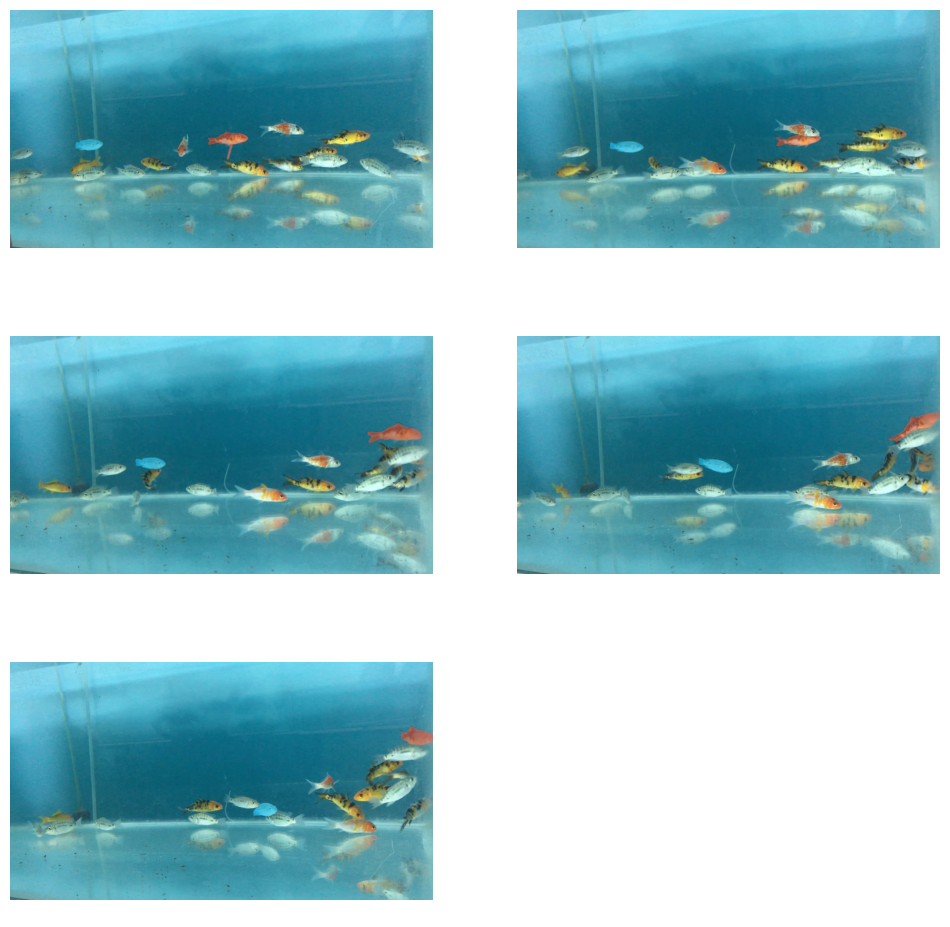

In [24]:
sv.plot_images_grid(
    images=frame_sample[:6],
    grid_size=(3, 2)
)

# Now let's train a YOLOv9 model



We will use YOLOv9.

Architecture in the repository:

https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/models/v9/yolov9c-seg.yaml


Why is it new?
- **Programmable Gradient Information (PGI)**: addresses the issue of data loss in deep networks, ensuring the retention of crucial features and the generation of reliable gradients for optimal training results
- **Generalized Efficient Layer Aggregation Network (GELAN)**: yields a network architecture that maximizes parameter utilization and computational efficiency

## Get dataset:
Create a shortcut to your google drive from this link:

https://drive.google.com/drive/u/1/folders/1J3SL52A8Z4mNdWI9yJ-B9tPWQdS00wjZ

into MyDrive/chess_pieces_dataset_link

In [ ]:
# Free memory, because you'll probably run out of it
# If that is not enough, restart the session
# If that is not enough, reduce batch size
del inference_state
del sam2_model
torch.cuda.empty_cache()
gc.collect()

In [25]:
#!cp -r /content/drive/MyDrive/chess_pieces_dataset_link/* /content/drive/MyDrive/chess_pieces_dataset/

Try the pre-trained model for a test image


0: 640x640 (no detections), 50.1ms
Speed: 5.0ms preprocess, 50.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


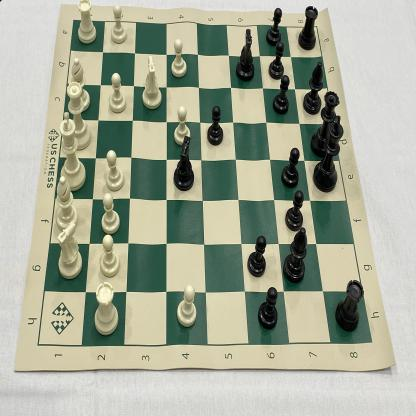

In [6]:
model = YOLO('yolov9c.pt')

# Read a test image
img = cv2.imread('/content/drive/MyDrive/chess_pieces_dataset/test/images/IMG_0170_JPG.rf.480e7164cb4727f6654402882f0ce942.jpg')

# Run prediction on the image
results = model.predict(img)

# Iterate over the results
for result in results:
    boxes = result.boxes.cpu().numpy()  # Get boxes on CPU in numpy format
    for box in boxes:  # Iterate over boxes
        r = box.xyxy[0].astype(int)  # Get corner points as int
        class_id = int(box.cls[0])  # Get class ID
        class_name = model.names[class_id]  # Get class name using the class ID
        print(f"Class: {class_name}, Box: {r}")  # Print class name and box coordinates
        cv2.rectangle(img, r[:2], r[2:], (0, 255, 0), 2)  # Draw boxes on the image

# Display the output image
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Train a YOLOv9 with pre-trained weights

In [6]:
#yaml_path = '/content/drive/MyDrive/chess_pieces_dataset/data.yaml'
yaml_path = '/content/segment-anything-2/data.yaml'

model = YOLO('yolov9c.pt') # for bounding boxes, to match the annotation!
try:
    model.train(data=yaml_path, \
                pretrained=True, \
                epochs=30, \
                save_period=5,\
                project= '/content/train_output', amp=False, batch=1)
except Exception as e:
    print(f"An exception occurred: {str(e)}")
    raise e

Ultralytics 8.3.11 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/content/segment-anything-2/data.yaml, epochs=30, time=None, patience=100, batch=1, imgsz=640, save=True, save_period=5, cache=False, device=None, workers=8, project=/content/train_output, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True

train: Scanning /content/drive/MyDrive/chess_pieces_dataset/train/labels.cache... 606 images, 0 backgrounds, 0 corrupt: 100%|██████████| 606/606 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/chess_pieces_dataset/train/images/26d663ab5ffbec49f9dc8e592982cfd4_jpg.rf.0fe973299ff9e73874d9e684cba4e406.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/chess_pieces_dataset/train/images/26d663ab5ffbec49f9dc8e592982cfd4_jpg.rf.5e1a9d49ad09f5a7549225a05e1f66a6.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/chess_pieces_dataset/train/images/26d663ab5ffbec49f9dc8e592982cfd4_jpg.rf.bb226be189ee3a6399fbbd5080852e5b.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/chess_pieces_dataset/valid/labels.cache... 58 images, 0 backgrounds, 0 corrupt: 100%|██████████| 58/58 [00:00<?, ?it/s]


Plotting labels to /content/train_output/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 160 weight(decay=0.0), 167 weight(decay=0.0005), 166 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/train_output/train6
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.03G      1.326      3.736      1.166         38        640: 100%|██████████| 606/606 [02:09<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.74it/s]


                   all         58        386      0.574      0.611      0.626      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       1.9G      1.323      2.388       1.16         71        640: 100%|██████████| 606/606 [01:59<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.52it/s]

                   all         58        386      0.643      0.894      0.837      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       1.9G      1.245      2.059      1.117         12        640: 100%|██████████| 606/606 [01:58<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.30it/s]

                   all         58        386       0.91      0.884      0.936      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      1.89G      1.231      1.799      1.121          3        640: 100%|██████████| 606/606 [01:59<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.93it/s]

                   all         58        386      0.866      0.921      0.959      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      1.89G      1.225      1.452      1.122         11        640: 100%|██████████| 606/606 [01:59<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.43it/s]

                   all         58        386      0.913      0.929      0.983      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      1.89G      1.156       1.39      1.075         15        640: 100%|██████████| 606/606 [01:56<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:03<00:00,  9.36it/s]

                   all         58        386      0.932      0.984      0.979      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      1.89G      1.154      1.287      1.088          0        640: 100%|██████████| 606/606 [01:58<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.58it/s]

                   all         58        386      0.974      0.971      0.984      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      1.89G       1.11       1.06      1.068          5        640: 100%|██████████| 606/606 [01:59<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.10it/s]

                   all         58        386      0.963      0.971      0.988      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      1.89G      1.101     0.9923      1.082          4        640: 100%|██████████| 606/606 [02:03<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.55it/s]

                   all         58        386      0.942      0.973      0.986      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      1.89G      1.082     0.9782      1.057          0        640: 100%|██████████| 606/606 [01:56<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.27it/s]

                   all         58        386      0.973      0.989      0.988      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      1.91G      1.026     0.9566      1.036         27        640: 100%|██████████| 606/606 [01:59<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.63it/s]

                   all         58        386      0.977      0.991      0.987      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      1.89G      1.025     0.8841       1.04          0        640: 100%|██████████| 606/606 [01:59<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.55it/s]

                   all         58        386      0.976      0.992      0.988       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      1.89G      1.027     0.8264      1.029         23        640: 100%|██████████| 606/606 [01:56<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:03<00:00,  8.15it/s]

                   all         58        386      0.984       0.99      0.988      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      1.89G      1.002     0.8372      1.025          3        640: 100%|██████████| 606/606 [01:58<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.05it/s]

                   all         58        386      0.981      0.993       0.99      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      1.89G     0.9799      0.785      1.017         16        640: 100%|██████████| 606/606 [01:58<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.56it/s]

                   all         58        386      0.985      0.989      0.989      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      1.89G     0.9801     0.7474      1.012          8        640: 100%|██████████| 606/606 [01:58<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:03<00:00,  9.52it/s]

                   all         58        386      0.983      0.993      0.989      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      1.89G     0.9809     0.7043       1.03          6        640: 100%|██████████| 606/606 [01:56<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.37it/s]

                   all         58        386      0.969       0.99      0.981      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      1.89G      0.963     0.6663       1.02          1        640: 100%|██████████| 606/606 [01:59<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.26it/s]

                   all         58        386      0.976       0.99      0.988       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      1.89G     0.9473     0.6674      1.005          1        640: 100%|██████████| 606/606 [01:59<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:03<00:00,  9.46it/s]

                   all         58        386      0.985      0.993      0.987      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      1.89G     0.9248      0.658     0.9998          6        640: 100%|██████████| 606/606 [01:59<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.55it/s]

                   all         58        386      0.987      0.991       0.99      0.776


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      1.89G     0.8568      0.657     0.9814          1        640: 100%|██████████| 606/606 [01:56<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.43it/s]

                   all         58        386      0.976      0.993      0.987      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      1.89G     0.8305     0.5866     0.9688         19        640: 100%|██████████| 606/606 [01:58<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.46it/s]

                   all         58        386      0.981      0.991      0.989      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      1.89G     0.8473     0.5967     0.9649         32        640: 100%|██████████| 606/606 [01:58<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.48it/s]

                   all         58        386      0.984      0.992      0.989      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      1.89G     0.7903     0.5757     0.9427         14        640: 100%|██████████| 606/606 [01:57<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00,  9.80it/s]

                   all         58        386      0.986      0.991      0.986      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      1.89G      0.788     0.5634     0.9531          1        640: 100%|██████████| 606/606 [01:54<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.67it/s]

                   all         58        386      0.986      0.993      0.987      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      1.89G     0.7636     0.5256     0.9438         14        640: 100%|██████████| 606/606 [01:55<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.65it/s]

                   all         58        386      0.984      0.993      0.986      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      1.89G     0.7332      0.509     0.9292          1        640: 100%|██████████| 606/606 [01:55<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.84it/s]

                   all         58        386      0.987      0.993      0.988      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      1.89G     0.7158     0.4898     0.9293         32        640: 100%|██████████| 606/606 [01:52<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.62it/s]

                   all         58        386      0.987      0.993      0.987      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      1.89G     0.6886      0.476      0.911         22        640: 100%|██████████| 606/606 [01:56<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.74it/s]

                   all         58        386      0.986      0.993      0.986      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      1.89G     0.6771      0.485     0.8995         17        640: 100%|██████████| 606/606 [01:56<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.52it/s]

                   all         58        386      0.986      0.993      0.986      0.775



30 epochs completed in 1.033 hours.
Optimizer stripped from /content/train_output/train6/weights/last.pt, 43.3MB
Optimizer stripped from /content/train_output/train6/weights/best.pt, 43.3MB

Validating /content/train_output/train6/weights/best.pt...
Ultralytics 8.3.11 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 402 layers, 21,155,447 parameters, 0 gradients, 82.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.30it/s]


                   all         58        386      0.987      0.993      0.988      0.779
          black-bishop         13         22      0.994      0.955      0.973      0.659
            black-king         29         29      0.996          1      0.995      0.832
          black-knight         26         30      0.998          1      0.995      0.817
            black-pawn         25         77      0.998          1      0.995      0.784
           black-queen         11         11      0.982          1      0.995      0.805
            black-rook         24         28      0.996          1      0.995       0.76
          white-bishop         17         22      0.954          1      0.983      0.747
            white-king         29         29      0.999          1      0.995      0.808
          white-knight         17         19      0.942          1      0.967      0.768
            white-pawn         26         77          1      0.999      0.995       0.78
           white-quee

# Inference with the best model for an unseen frame

In [ ]:
!ls -la /content/train_output/


0: 640x640 2 black-bishops, 1 black-king, 2 black-knights, 8 black-pawns, 1 black-queen, 2 black-rooks, 2 white-bishops, 1 white-king, 2 white-knights, 8 white-pawns, 2 white-queens, 2 white-rooks, 60.3ms
Speed: 5.4ms preprocess, 60.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)
Class: white-queen, Box: [ 64  80  93 151]
Class: white-knight, Box: [ 53 221  84 280]
Class: black-queen, Box: [311  87 342 157]
Class: white-bishop, Box: [ 68  55  92 113]
Class: white-rook, Box: [ 92 280 121 337]
Class: black-king, Box: [313 113 344 194]
Class: white-rook, Box: [74  0 97 45]
Class: white-pawn, Box: [171 103 192 146]
Class: black-bishop, Box: [302  59 324 116]
Class: black-pawn, Box: [205 103 224 147]
Class: white-pawn, Box: [175 281 200 329]
Class: white-king, Box: [ 56 110  87 192]
Class: black-pawn, Box: [271  73 291 116]
Class: black-bishop, Box: [282 226 308 285]
Class: white-bishop, Box: [ 53 174  78 232]
Class: black-pawn, Box: [246 231 269 279]
Class: black-pawn

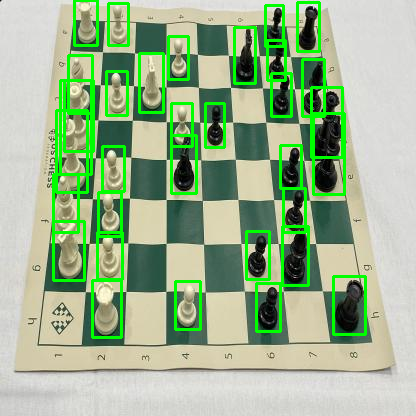

In [10]:
# Run prediction on the image
# Iterate over the results
# Display the output image

model = YOLO('/content/train_output/train6/weights/best.pt')

# Read the image
img = cv2.imread('/content/drive/MyDrive/chess_pieces_dataset/test/images/IMG_0170_JPG.rf.480e7164cb4727f6654402882f0ce942.jpg')

# Run prediction on the image
results = model.predict(img)

# Iterate over the results
for result in results:
    boxes = result.boxes.cpu().numpy()  # Get boxes on CPU in numpy format
    for box in boxes:  # Iterate over boxes
        r = box.xyxy[0].astype(int)  # Get corner points as int
        class_id = int(box.cls[0])  # Get class ID
        class_name = model.names[class_id]  # Get class name using the class ID
        print(f"Class: {class_name}, Box: {r}")  # Print class name and box coordinates
        cv2.rectangle(img, r[:2], r[2:], (0, 255, 0), 2)  # Draw boxes on the image

# Display the output image
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Tensorboard

https://docs.ultralytics.com/integrations/tensorboard/

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/train_output/train6